In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import abc
import tensorflow as tf
import numpy as np

from tf_agents.environments import py_environment
from tf_agents.environments import tf_environment
from tf_agents.environments import tf_py_environment
from tf_agents.environments import utils
from tf_agents.specs import array_spec, tensor_spec
from tf_agents.environments import wrappers
from tf_agents.trajectories import time_step as ts
from tf_agents.trajectories import policy_step as ps
from tf_agents.typing import types
from tf_agents.policies import random_py_policy
from tf_agents.policies import epsilon_greedy_policy
from tf_agents.policies import random_tf_policy
from tf_agents.policies import py_policy
from tf_agents.metrics import py_metrics
from tf_agents.metrics import tf_metrics
from tf_agents.drivers import py_driver
from tf_agents.drivers import tf_driver
from tf_agents.drivers import dynamic_episode_driver
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.drivers import dynamic_step_driver
from tf_agents.policies import py_tf_eager_policy
from tf_agents.networks import actor_distribution_network
from tf_agents.networks import value_network
from tf_agents.networks import value_rnn_network
from tf_agents.agents import PPOAgent
from tf_agents.utils import common as cmn

import matplotlib.pyplot as plt
import qutip
from qutip import expect, basis, sigmap, sigmam, fidelity

from tqdm.auto import trange
import time

import random

import sys
sys.path.append('../')
from common.common import get_average_return, extract_trigonometric_controls

%matplotlib inline

2024-03-12 08:08:16.304299: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-12 08:08:16.327909: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-12 08:08:16.327930: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-12 08:08:16.328707: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-12 08:08:16.333206: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-12 08:08:16.333730: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
T = 3.15 # terminal time step
max_steps = 300 # number of time steps
random.seed(1989)
tf.random.set_seed(1989)

In [3]:
# validate environment
from environments.qubit_cont_func_env import QubitContEnvContFunc

# define actions
# actions can be represented as trigonometric series, we are searching for optimal parameters
max_Ω = 1.0
max_Δ = 0.5
fidelity_threshold = 0.9999

environment = QubitContEnvContFunc(T, max_steps, max_Ω, max_Δ = max_Δ, fidelity_threshold = fidelity_threshold, verbose_fg = False, nb_harmonics = 3)
eval_environment = QubitContEnvContFunc(T, max_steps, max_Ω, max_Δ = max_Δ, fidelity_threshold = fidelity_threshold, verbose_fg = False, nb_harmonics = 3)

train_env = tf_py_environment.TFPyEnvironment(environment)
eval_env = tf_py_environment.TFPyEnvironment(eval_environment)

In [4]:
fc_layer_params = (100, 100, 50)
learning_rate = 2e-3
replay_buffer_capacity = 100000
num_iterations = 10000
nb_episodes = 1
eval_interval = 10
checkpoint_dir = "../checkpoints/ppo_qubit_trigonometric_series/"

In [5]:
actor_network = actor_distribution_network.ActorDistributionNetwork(
    input_tensor_spec = train_env.observation_spec(),
    output_tensor_spec = train_env.action_spec(),
    fc_layer_params = fc_layer_params,
    activation_fn = tf.keras.activations.relu,
    name = "Policy",
)

# use tha Adam optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)

train_step_counter = tf.Variable(0)

value_net = value_network.ValueNetwork(
    input_tensor_spec = train_env.observation_spec(),
    fc_layer_params = (75, 75, 50),
    name = 'ValueNet'
)

agent = PPOAgent(
    time_step_spec = train_env.time_step_spec(),
    action_spec = train_env.action_spec(),
    actor_net = actor_network,
    value_net = value_net,
    optimizer = optimizer,
    train_step_counter = train_step_counter,
)

agent.initialize()

2024-03-12 08:08:18.082901: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:129] retrieving CUDA diagnostic information for host: dkoytrom-pc
2024-03-12 08:08:18.082915: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:136] hostname: dkoytrom-pc
2024-03-12 08:08:18.082987: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:159] libcuda reported version is: NOT_FOUND: was unable to find libcuda.so DSO loaded into this program
2024-03-12 08:08:18.083008: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] kernel reported version is: 550.54.14


In [6]:
# collect trajectories
import reverb
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils

table_name = 'uniform_table'
replay_buffer_signature = tensor_spec.from_spec(agent.collect_data_spec)
replay_buffer_signature = tensor_spec.add_outer_dim(replay_buffer_signature)

table = reverb.Table(
    table_name,
    max_size = replay_buffer_capacity,
    sampler = reverb.selectors.Uniform(),
    remover = reverb.selectors.Fifo(),
    rate_limiter = reverb.rate_limiters.MinSize(1),
    signature = replay_buffer_signature
)

reverb_server = reverb.Server([table])

replay_buffer = reverb_replay_buffer.ReverbReplayBuffer(
    agent.collect_data_spec,
    table_name = table_name,
    sequence_length = None,
    local_server = reverb_server
)

rb_observer = reverb_utils.ReverbAddEpisodeObserver(
    replay_buffer.py_client,
    table_name,
    replay_buffer_capacity
)

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = cmn.function(agent.train)

# Reset the train step.
# agent.train_step_counter.assign(0)

# create a driver which will run the simulations and collect tha dataset for our training
collect_driver = py_driver.PyDriver(
    environment,
    py_tf_eager_policy.PyTFEagerPolicy(agent.collect_policy, use_tf_function = True),
    observers = [rb_observer],
    max_episodes = nb_episodes
)

# create checkpointer to load training and continue
""" checkpointer = cmn.Checkpointer(
    ckpt_dir = checkpoint_dir,
    max_to_keep = 1,
    agent = agent,
    policy = agent.policy,
    replay_buffer = replay_buffer,
)

checkpointer.initialize_or_restore() """

[reverb/cc/platform/tfrecord_checkpointer.cc:162]  Initializing TFRecordCheckpointer in /tmp/tmp5y9cjnhs.
[reverb/cc/platform/tfrecord_checkpointer.cc:565] Loading latest checkpoint from /tmp/tmp5y9cjnhs
[reverb/cc/platform/default/server.cc:71] Started replay server on port 41181


' checkpointer = cmn.Checkpointer(\n    ckpt_dir = checkpoint_dir,\n    max_to_keep = 1,\n    agent = agent,\n    policy = agent.policy,\n    replay_buffer = replay_buffer,\n)\n\ncheckpointer.initialize_or_restore() '

In [7]:
with trange(num_iterations, dynamic_ncols = False) as tbar:
    for _ in tbar:
        initial_time_step = environment.reset()
        collect_driver.run(initial_time_step)

        # if threshold fidelity achieved, stop training
        # if environment.max_fidelity >= 0.9999:
        if environment.max_fidelity >= fidelity_threshold:
            break

        # create dataset from trajectories
        dataset = replay_buffer.as_dataset(sample_batch_size = 1)
        iterator = iter(dataset)

        trajectories , _ = next(iterator)

        # train 
        train_loss = agent.train(experience = trajectories)

        replay_buffer.clear()

        step = agent.train_step_counter.numpy()

        if step % 10 == 0:
            tbar.set_postfix({"step": step, "loss": train_loss.loss.numpy(), "max fidelity": environment.max_fidelity})

 11%|█         | 1085/10000 [03:29<28:37,  5.19it/s, step=27100, loss=0.384, max fidelity=1]

 fidelity   =  0.99999 [ 0.87517912  0.20610334  0.16243254  0.02755164 -0.03201709 -0.18376116
  0.11923808] [ 0.07352462 -0.13624175 -0.09679438  0.02831635  0.22532735 -0.10505782
  0.13957184]


In [8]:
omega_params = environment.optimal_omega_params
detuning_params = environment.optimal_detuning_params
states = environment.states
desired_state = basis(2, 1)
fidelities = [fidelity(desired_state, state) ** 2 for state in states]

nb_harmonics = environment._nb_harmonics

def omega(t, args):
    Ω = omega_params[0]

    for harmonic in range(1, nb_harmonics + 1):
        Ω += omega_params[2 * harmonic - 1] * np.cos(harmonic * t) + omega_params[2 * harmonic] * np.sin(harmonic * t)

    return Ω

def detuning(t, args):
    Δ = detuning_params[0]

    for harmonic in range(1, nb_harmonics + 1):
        Δ += detuning_params[2 * harmonic - 1] * np.cos(harmonic * t) + detuning_params[2 * harmonic] * np.sin(harmonic * t)

    return Δ

time_span = np.linspace(start = 0, stop = T, num = max_steps)

omegas = [omega(t, args = None) for t in time_span]
detunings = [detuning(t, args = None) for t in time_span]

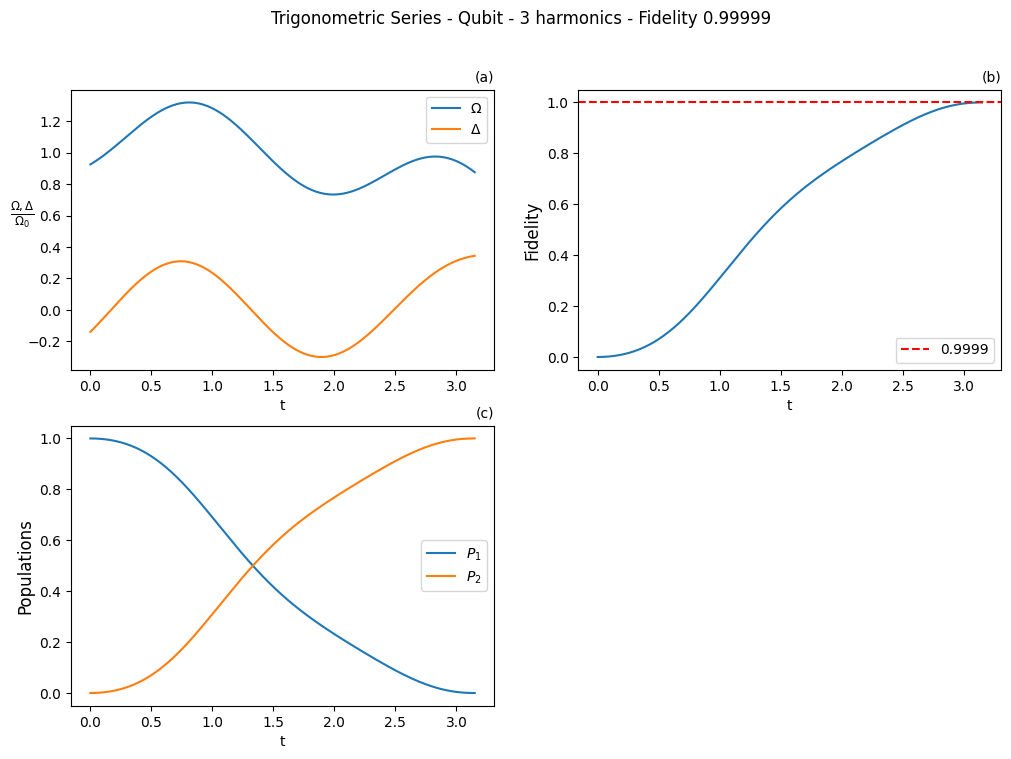

In [9]:
population2 = expect(sigmap().dag() * sigmap(), states)
population1 = 1 - population2

# fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig = plt.figure()
gs = fig.add_gridspec(2, 2)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax4 = fig.add_subplot(gs[1, :-1])
fig.set_figheight(8)
fig.set_figwidth(12)
fig.suptitle(f"Trigonometric Series - Qubit - {nb_harmonics} harmonics - Fidelity {round(environment.max_fidelity, 5)}")

ax1.plot(time_span, omegas, label = 'Ω')
ax1.plot(time_span, detunings, label = 'Δ')
ax1.set_ylabel(r"$\frac{Ω,Δ}{\Omega_0}$", rotation = 0, fontsize = 12)
ax1.set_xlabel(r"t")
ax1.set_title("(a)", loc = "right", fontsize = 10)
ax1.legend()

ax2.plot(time_span, fidelities)
ax2.axhline(y = 0.9999, color = 'r', linestyle = '--', label = '0.9999')
ax2.set_ylabel("Fidelity", rotation = 90, fontsize = 12)
ax2.set_xlabel(r"t")
ax2.set_title("(b)", loc = "right", fontsize = 10)
ax2.legend(loc = 'lower right')

ax4.plot(time_span, population1, label = r"$P_1$")
ax4.plot(time_span, population2, label = r"$P_2$")
ax4.set_ylabel("Populations", rotation = 90, fontsize = 12)
ax4.set_xlabel(r"t")
ax4.set_title("(c)", loc = "right", fontsize = 10)
ax4.legend()

In [10]:
fidelities

[0.0,
 2.3869490443018105e-05,
 9.598627379482982e-05,
 0.00021713410949032394,
 0.0003881248071568189,
 0.0006097972804826741,
 0.0008830165209817806,
 0.0012086724908038937,
 0.0015876789339058727,
 0.0020209721050445635,
 0.0025095094161966423,
 0.0030542680001172133,
 0.0036562431745219186,
 0.004316446840898257,
 0.005035905814344997,
 0.005815660060640505,
 0.006656760853184031,
 0.007560268851314304,
 0.008527252102118877,
 0.009558783968695984,
 0.010655940988710972,
 0.011819800667153687,
 0.013051439205176244,
 0.014351914120251058,
 0.015722304706112765,
 0.01716366882368187,
 0.018677053290187307,
 0.020263491300064673,
 0.021923999804855696,
 0.02365957685748344,
 0.02547119892546723,
 0.027359818177995984,
 0.029326359752439173,
 0.03137171900646767,
 0.03349675876242474,
 0.035702306550958345,
 0.037989151861228206,
 0.04035804340526086,
 0.042809686404247566,
 0.04534473990477185,
 0.04796381413311229,
 0.05066746789589327,
 0.053456206035450766,
 0.056330476948337586,


In [11]:
omega_params

array([ 0.87517912,  0.20610334,  0.16243254,  0.02755164, -0.03201709,
       -0.18376116,  0.11923808])

In [12]:
detuning_params

array([ 0.07352462, -0.13624175, -0.09679438,  0.02831635,  0.22532735,
       -0.10505782,  0.13957184])